In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import os
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import joblib
import smtplib
import ssl
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import time
from datetime import datetime

In [3]:
zip_code = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/barcelona_grouped_codigo_distrito.csv', sep = ";")
zip_code['zip_code'].unique()

array([8911, 8915, 8910, 8914, 8918, 8912, 8917, 8913, 8923, 8001, 8002,
       8003, 8007, 8010, 8004, 8011, 8015, 8039, 8018, 8013, 8006, 8008,
       8021, 8025, 8029, 8036, 8009, 8037, 8014, 8026, 8024, 8023, 8032,
       8035, 8012, 8041, 8031, 8016, 8027, 8022, 8028, 8034, 8094, 8903,
       8904, 8905, 8017, 8906, 8042, 8033, 8110, 8030, 8922, 8019, 8071,
       8020, 8930, 8005, 5030, 8038, 8902, 8196, 8907, 8991, 8096, 8901,
       8950, 8940, 8801, 8908])

In [12]:
barcelona = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/barcelona_distancias_servicios_final.csv', sep = ";")
barcelona.replace('No data', 0, inplace = True)
barcelona.replace(False, 0, inplace = True)
barcelona.replace(True, 1, inplace = True)
barcelona.replace('False', 0, inplace = True)
barcelona.replace('True', 1, inplace = True)

In [4]:
encuesta = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/google_forms_corregido.csv', sep= ";")
map_distrito_to_zip = dict(zip(zip_code['neighborhood'], zip_code['zip_code']))
encuesta['distrito_1'] = encuesta['distrito_1'].map(map_distrito_to_zip)
encuesta['distrito_2'] = encuesta['distrito_2'].map(map_distrito_to_zip)
encuesta.replace(False, 0, inplace = True)
encuesta.replace(True, 1, inplace = True)

In [5]:
encuesta.columns

Index(['Marca temporal', 'Dirección de correo electrónico', 'distrito_1',
       'distrito_2', 'farmacias', 'hospitales', 'escuelas', 'supermercados',
       'gimnasio', 'cinema', 'centros_comerciales', 'restaurantes', 'parques',
       'tipo_vivienda', 'budget', 'tamaño', 'rooms', 'bathrooms',
       'caracteristicas', 'edad', 'estudios', 'ingresos', 'air_conditioning',
       'terrace', 'garden', 'parking', 'swimming_pool', 'booxroom'],
      dtype='object')

In [6]:
encuesta['budget'].mean()

231277.55102040817

In [14]:
barcelona_zip_price = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/zip_mean_log_price.csv', sep = ";")
barcelona_zip_price

,zip_code,zip_mean_price,price_m2_mean_log
0,8010,14.060566,8.978610
1,8008,13.807605,9.000411
2,8007,14.237496,9.169621
3,8003,13.185494,8.660511
4,8003,13.185494,8.660511
...,...,...,...
8913,8034,14.093444,8.850762
8914,8034,14.093444,8.850762
8915,8017,14.305278,8.643760
8916,8017,14.305278,8.643760


In [15]:
barcelona_zip_price1 = barcelona_zip_price[['zip_code','zip_mean_price']]
barcelona_zip_price2 = barcelona_zip_price[['zip_code','price_m2_mean_log']]

In [ ]:
# Para cada distrito se asigna el precio medio del zip_code correspondiente

map_zip_mean_price = barcelona_zip_price.set_index('zip_code')['zip_mean_price'].to_dict()
map_price_m2_log = barcelona_zip_price.set_index('zip_code')['price_m2_mean_log'].to_dict()
encuesta['log_price_distrito_1'] = encuesta['distrito_1'].map(map_zip_mean_price)
encuesta['log_price_distrito_2'] = encuesta['distrito_2'].map(map_zip_mean_price)

encuesta['price_m2_mean_log_distrito_1'] = encuesta['distrito_1'].map(map_price_m2_log)
encuesta['price_m2_mean_log_distrito_2'] = encuesta['distrito_2'].map(map_price_m2_log)


In [ ]:
encuesta2 = encuesta.copy()

columns_to_modify = ['bathrooms', 'air_conditioning', 'terrace', 'garden', 'parking', 'swimming_pool', 'booxroom']
encuesta2[columns_to_modify] = encuesta2[columns_to_modify].replace({0: False, 1: True})

In [22]:
encuesta2[['distrito_1',
       'distrito_2','log_price_distrito_1', 'log_price_distrito_2',
       'price_m2_mean_log_distrito_1', 'price_m2_mean_log_distrito_2' ]]

,distrito_1,distrito_2,log_price_distrito_1,log_price_distrito_2,price_m2_mean_log_distrito_1,price_m2_mean_log_distrito_2
0,8071,8018,13.628183,12.835986,8.845676,8.417004
1,8071,8037,13.628183,13.260955,8.845676,8.680964
2,8914,8034,11.820603,14.093444,7.515429,8.850762
3,8034,8015,14.093444,12.937028,8.850762,8.464560
4,8917,8918,12.116879,11.913403,7.721672,7.489001
...,...,...,...,...,...,...
93,8034,8906,14.093444,11.917453,8.850762,7.725921
94,8035,8036,12.302876,13.695019,7.940505,8.797141
95,8034,8903,14.093444,12.349173,8.850762,8.051441
96,8034,8903,14.093444,12.349173,8.850762,8.051441


In [ ]:
# Para cada distrito se asigna el precio medio del zip_code correspondiente
map_zip_to_distrito = dict(zip(zip_code['zip_code'], zip_code['neighborhood']))
encuesta2['distrito_1_original'] = encuesta2['distrito_1']
encuesta2['distrito_2_original'] = encuesta2['distrito_2']

encuesta2['distrito_1'] = encuesta2['distrito_1'].map(map_zip_to_distrito)
encuesta2['distrito_2'] = encuesta2['distrito_2'].map(map_zip_to_distrito)

In [ ]:
# Predecimos los precios de los inmuebles ideales de los usuarios segun sus preferencia y por cada barrio

xgb_model_prova_1 = joblib.load('xgboost_model.pkl')


def predict_price_for_district(distrito_value, encuesta_row, distrito_prefix):
    if pd.isna(distrito_value): 
        return np.nan

    zip_mean_price_col = f'log_price_{distrito_prefix}'
    price_m2_mean_log_col = f'price_m2_mean_log_{distrito_prefix}'

    if zip_mean_price_col not in encuesta_row or price_m2_mean_log_col not in encuesta_row:
        return np.nan

    zip_code_value = encuesta_row[distrito_prefix]
    
    if pd.isna(zip_code_value):
        return np.nan

    input_data = pd.DataFrame({
        'propertyType': [encuesta_row['tipo_vivienda']],  
        'size': [encuesta_row['tamaño']],
        'exterior': [True],  
        'rooms': [encuesta_row['rooms']],
        'bathrooms': [encuesta_row['bathrooms']],
        'hasLift': [True],  
        'hasParkingSpace': [encuesta_row['parking']],
        'hasSwimmingPool': [encuesta_row['swimming_pool']],
        'hasTerrace': [encuesta_row['terrace']],
        'hasAirConditioning': [encuesta_row['air_conditioning']],
        'hasBoxRoom': [encuesta_row['booxroom']],
        'hasGarden': [encuesta_row['garden']],
        'zip_code': [zip_code_value],  
        'zip_mean_price': [encuesta_row[zip_mean_price_col]], 
        'price_m2_mean_log': [encuesta_row[price_m2_mean_log_col]] 
    })
    input_data = pd.get_dummies(input_data, drop_first=True)

    model_columns = xgb_model_prova_1.get_booster().feature_names
    input_data = input_data.reindex(columns=model_columns, fill_value=0)

    predicted_log_price = xgb_model_prova_1.predict(input_data)

    return np.exp(predicted_log_price[0])
encuesta2['precio_predicho_distrito_1'] = encuesta2.apply(
    lambda row: predict_price_for_district(row['distrito_1'], row, 'distrito_1'), axis=1
)

encuesta2['precio_predicho_distrito_2'] = encuesta2.apply(
    lambda row: predict_price_for_district(row['distrito_2'], row, 'distrito_2'), axis=1
)



🔍 ZIP CODES disponibles en zip_code DataFrame:
   zip_code      neighborhood
0      8911           Canyadó
1      8911         Casagemes
2      8911         Casagemes
3      8915         Casagemes
4      8911  Manresa Badalona

🔍 Valores mapeados en encuesta2:
  distrito_1_original   distrito_1              distrito_2_original  \
0         El Poblenou  El Poblenou         Sant Martí de Provençals   
1         El Poblenou  El Poblenou                   Vila de Gràcia   
2            Puigfred     Puigfred                           Sarrià   
3              Sarrià       Sarrià  El Poble Sec - Parc de Montjuïc   
4          Sant Crist   Sant Crist                         Sant Roc   

                        distrito_2  
0         Sant Martí de Provençals  
1                   Vila de Gràcia  
2                           Sarrià  
3  El Poble Sec - Parc de Montjuïc  
4                         Sant Roc  

📌 Predicción para distrito_1: El Poblenou
  propertyType   size  exterior  rooms  bathroo

In [28]:
encuesta2 ['diferencia_dist_1'] = encuesta2['precio_predicho_distrito_1'] - encuesta2['budget']
encuesta2 ['diferencia_dist_2'] = encuesta2['precio_predicho_distrito_2'] - encuesta2['budget']

In [ ]:
# Creamos una ratio para el valor asignar un mensaje según el presupuesto y el precio predicho por el moedelo


for e in range(encuesta2.shape[0]):
    ratio = encuesta2['budget'].iloc[e] / encuesta2['precio_predicho_distrito_1'].iloc[e]
    
    if ratio <= 0.985:
        encuesta2.at[e, 'resultado_dist_1'] = 'Quiza deberias aumentar tu presupuesto para este barrio'
    elif 0.985 < ratio < 1.016:
        encuesta2.at[e, 'resultado_dist_1'] = 'El presupuesto se ajusta a las caractaristicas de la inmueble'
    elif ratio >= 1.016:
        encuesta2.at[e, 'resultado_dist_1'] = 'Enorabuena, tu pressupuesto es menor que el precio del inmueble'

for e in range(encuesta2.shape[0]):
    ratio = encuesta2['budget'].iloc[e] / encuesta2['precio_predicho_distrito_2'].iloc[e]
    
    if ratio <= 0.985:
        encuesta2.at[e, 'resultado_dist_2'] = 'Quiza deberias aumentar tu presupuesto para este barrio'
    elif 0.985 < ratio < 1.016:
        encuesta2.at[e, 'resultado_dist_2'] = 'El presupuesto se ajusta a las caractaristicas de la inmueble'
    elif ratio >= 1.016:
        encuesta2.at[e, 'resultado_dist_2'] = 'Enorabuena, tu pressupuesto es menor que el precio del inmueble'

In [ ]:
# Damos formato a euros y m2
encuesta2['budget'] = encuesta2['budget'].apply(lambda x: f"{x:,.2f}€")
encuesta2['precio_predicho_distrito_1'] = encuesta2['precio_predicho_distrito_1'].apply(lambda x: f"{x:,.2f}€")
encuesta2['precio_predicho_distrito_2'] = encuesta2['precio_predicho_distrito_2'].apply(lambda x: f"{x:,.2f}€")
encuesta2['tamaño'] = encuesta2['tamaño'].apply(lambda x: f"{int(x)} m²")
encuesta2['rooms'] = encuesta2['rooms'].apply(lambda x: f"{int(x)}")

In [ ]:
encuesta = encuesta[['Dirección de correo electrónico', 'distrito_1',
       'distrito_2', 'farmacias', 'hospitales', 'escuelas', 'supermercados',
       'gimnasio', 'cinema', 'centros_comerciales', 'parques',
       'tipo_vivienda', 'budget', 'tamaño', 'rooms', 'bathrooms', 'air_conditioning', 'terrace', 'garden', 'parking', 'swimming_pool',
       'booxroom']]

Index(['Dirección de correo electrónico', 'distrito_1', 'distrito_2',
       'farmacias', 'hospitales', 'escuelas', 'supermercados', 'gimnasio',
       'cinema', 'centros_comerciales', 'parques', 'tipo_vivienda', 'budget',
       'tamaño', 'rooms', 'bathrooms', 'air_conditioning', 'terrace', 'garden',
       'parking', 'swimming_pool', 'booxroom'],
      dtype='object')

In [32]:
barcelona_url = barcelona[['propertyCode','url']]

In [33]:
barcelona_zip_price = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/zip_mean_log_price.csv', sep = ";")

In [34]:
barcelona_zip_price = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/zip_mean_log_price.csv', sep = ";")

In [35]:
barcelona_price_model = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/result_barcelona_price_predict.csv', sep = ";")
barcelona_price_model = barcelona_price_model[['price_pred', 'propertyCode', 'desviations',
       'deviacion_class']]

In [ ]:


resultados_todos_juntos = pd.read_csv(
    f'/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Respuestas/Respuesta_viviendas.csv',
    sep=";"
)

# Se realiza un for para recorer todo el dataset y personalizar el resultado para cada usuario
for encuestado in range(len(encuesta['Dirección de correo electrónico'])): 

    print(f"{encuestado} {encuesta['Dirección de correo electrónico'].iloc[encuestado]}")
    
    # Calculamos la puntuación del inumeble segun la distancias a los servicios, ponderado segun la puntuación de cada usuario
    barcelona['puntuacio'] = (
        barcelona['Centro_comercial_distancia'] / (encuesta['centros_comerciales'].iloc[encuestado] + 1) +
        barcelona['distancia_cinema'] / (encuesta['cinema'].iloc[encuestado] + 1) +
        barcelona['Parque_distancia'] / (encuesta['parques'].iloc[encuestado] + 1) +
        barcelona['Gimnasio _distancia'] / (encuesta['gimnasio'].iloc[encuestado] + 1) +
        barcelona['Supermercado_distancia'] / (encuesta['supermercados'].iloc[encuestado] + 1) +
        barcelona['Teatro _distancia'] / (encuesta['cinema'].iloc[encuestado] + 1) +
        barcelona['distancia_farmacias'] / (encuesta['farmacias'].iloc[encuestado] + 1) +
        barcelona['escuelas_distancia'] / (encuesta['escuelas'].iloc[encuestado] + 1)
    )
    
    barcelona_atributos_viviendas = barcelona[[
        'propertyCode',  'price', 'size', 'rooms', 'bathrooms', 'hasParkingSpace', 
        'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 
        'hasGarden', 'propertyType', 'zip_code', 'puntuacio'
    ]]
    
    # Filtramos el dataset de viviendas segun los distritos y el presupuesto del usuario

    barcelona_atributos_viviendas = barcelona_atributos_viviendas[
        ((barcelona_atributos_viviendas['zip_code'] == encuesta['distrito_1'].iloc[encuestado]) | 
        (barcelona_atributos_viviendas['zip_code'] == encuesta['distrito_2'].iloc[encuestado])) & 
        (barcelona_atributos_viviendas['price'].between(
            encuesta['budget'].iloc[encuestado] - 150000, 
            encuesta['budget'].iloc[encuestado] + 150000
        ))
]
    encuesta_0 = encuesta[[
        'tipo_vivienda', 'budget', 'tamaño', 'rooms', 'bathrooms', 'air_conditioning',
        'terrace', 'garden', 'parking', 'swimming_pool', 'booxroom'
    ]]
    
    encuesta_0_renamed = encuesta_0.rename(columns={
        'tipo_vivienda': 'propertyType',
        'budget': 'price',
        'tamaño': 'size',
        'rooms': 'rooms',
        'bathrooms': 'bathrooms',
        'air_conditioning': 'hasAirConditioning',
        'terrace': 'hasTerrace',
        'garden': 'hasGarden',
        'parking': 'hasParkingSpace',
        'swimming_pool': 'hasSwimmingPool',
        'booxroom': 'hasBoxRoom'
    })

    # Codificamos las variables categoricas y normalizamos los datos

    encuesta_0_encoded = pd.get_dummies(encuesta_0_renamed, columns=['propertyType'], drop_first=True)
    barcelona_atributos_viviendas_encoded = pd.get_dummies(barcelona_atributos_viviendas, columns=['propertyType'], drop_first=True)

    all_columns = sorted(set(encuesta_0_encoded.columns) | set(barcelona_atributos_viviendas_encoded.columns))
    encuesta_0_encoded = encuesta_0_encoded.reindex(columns=all_columns, fill_value=0)
    barcelona_atributos_viviendas_encoded = barcelona_atributos_viviendas_encoded.reindex(columns=all_columns, fill_value=0)

    # Assignamos los pesos al KNN
    pesos = {
        'price': 10, 
        'size': 9.0,   
        'rooms': 7.0,
        'bathrooms': 5.0,
        'hasAirConditioning': 1.0,
        'hasTerrace': 7.0,
        'hasGarden': 7.0,
        'hasParkingSpace': 5.0,
        'hasSwimmingPool': 5.0,
        'hasBoxRoom': 5.0,
    }
    
    for column in encuesta_0_encoded.columns:
        if column in pesos:
            encuesta_0_encoded[column] *= pesos[column]
            barcelona_atributos_viviendas_encoded[column] *= pesos[column]

    scaler = StandardScaler()
    encuesta_normalized = scaler.fit_transform(encuesta_0_encoded)
    barcelona_atributos_viviendas_normalized = scaler.transform(barcelona_atributos_viviendas_encoded)

    # Aplicamos el modelo de KNN para encontrar las 5 viviendas más cercanas a lo que el usuario quiera
    knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    knn.fit(barcelona_atributos_viviendas_normalized)
    distances, indices = knn.kneighbors(encuesta_normalized, n_neighbors=min(5, len(barcelona_atributos_viviendas_normalized)))

    resultados = barcelona_atributos_viviendas.iloc[indices[0]].copy()
    resultados.loc[:, 'origen_vivienda'] = "modelo_precio"

    resultados = pd.merge(resultados, barcelona_url, on='propertyCode', how='left')
    resultados = resultados[[
        'propertyCode', 'url','price', 'size', 'rooms', 'bathrooms', 'hasParkingSpace', 
        'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 
        'hasGarden', 'propertyType', 'zip_code', 'puntuacio','origen_vivienda'
    ]]
    
    resultados = pd.merge(resultados, barcelona_price_model, on='propertyCode', how='left')

    # Asignamos 5 viviendas aleatorias para cada usuario, esto nos permitira poder evaluar el modelo mediante un google forms

    if barcelona_atributos_viviendas.shape[0] >= 5:
        barcelona_atributos_viviendas = barcelona[[
        'propertyCode',  'price', 'size', 'rooms', 'bathrooms', 'hasParkingSpace', 
        'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 
        'hasGarden', 'propertyType', 'zip_code', 'puntuacio']][
            ((barcelona['zip_code'] == encuesta['distrito_1'].iloc[encuestado]) | 
            (barcelona['zip_code'] == encuesta['distrito_2'].iloc[encuestado]))]
        random_barcelona = barcelona_atributos_viviendas.sample(5)
        print(f"tot el dataframe ")
        
    else: 
        barcelona2 = barcelona[[
        'propertyCode',  'price', 'size', 'rooms', 'bathrooms', 'hasParkingSpace', 
        'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 
        'hasGarden', 'propertyType', 'zip_code', 'puntuacio']]
        barcelona2 = barcelona2[barcelona2['zip_code'].notnull()]
        random_barcelona = barcelona2.sample(5)
        print(f"No ha pogut entrar al dataframe ")


    # Juntamos los dos datasets y organizamos las columnas
    random_barcelona = pd.merge(random_barcelona, barcelona_price_model, on='propertyCode', how='left')
    random_barcelona.loc[:, 'origen_vivienda'] = 'random'
    random_barcelona = pd.merge(random_barcelona, barcelona_url, on='propertyCode', how='left')
    random_barcelona = random_barcelona[[
        'propertyCode', 'url','price', 'size', 'rooms', 'bathrooms', 'hasParkingSpace', 
        'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 
        'hasGarden', 'propertyType', 'zip_code', 'puntuacio', 'origen_vivienda', 
        'price_pred', 'desviations', 'deviacion_class'
    ]]

    print(resultados.columns)
    print(random_barcelona.columns)
    resultados = pd.concat([resultados, random_barcelona], ignore_index=True)

    # Asignamos un mensaje segun el ratio entre el precio del inmueble de mercado y el precio predicho

    for e in range(resultados.shape[0]):
        ratio = resultados['price'].iloc[e] / resultados['price_pred'].iloc[e]
        
        if ratio <= 0.985:
            resultados.at[e, 'Calidad/precio'] = 'Buena oportunidad'
        elif 0.985 < ratio < 1.016:
            resultados.at[e, 'Calidad/precio'] = 'Precio justo'
        elif ratio >= 1.016:
            resultados.at[e, 'Calidad/precio'] = 'Usa el precio predicho para negociar'

    resultados['diferencia'] = resultados['price'] - resultados['price_pred']
    resultados['ratio'] = resultados['price'] / resultados['price_pred']

    resultados = resultados.sample(frac=1).reset_index(drop=True)

    map_zip_to_distrito = dict(zip(zip_code['zip_code'], zip_code['neighborhood']))

    resultados['barrio'] = 0
    resultados.loc[:, 'barrio'] = resultados['zip_code'].map(map_zip_to_distrito)

    # Añadimos la información del usuario y la fecha de realización por si hubiera algun error porder localizar cual es el dataset enviado 

    resultados['correo_electronico'] = encuesta['Dirección de correo electrónico'].iloc[encuestado]
    resultados['fecha_realización'] = datetime.today()
    resultados_todos_juntos = pd.concat([resultados_todos_juntos, resultados], ignore_index=True)

    resultados['Indice'] = resultados.index + 1
    resultados = resultados[[
        'Indice', 'url', 'price', 'size', 'rooms', 'bathrooms', 'hasParkingSpace', 
        'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 
        'hasGarden', 'propertyType', 'zip_code', 'price_pred', 'Calidad/precio', 
        'diferencia'
    ]]
    
    # Juntamos las caracteristicas de la vivienda para mayor comprensión del usuario

    resultados['Caracteristicas'] = resultados.apply(
        lambda row: ', '.join([
            feature for feature, value in zip(
                ["Parking / Car park", "Piscina / Swimming pool", "Terraza / Balcony", 'Aire acondicionado / Air Conditioning', 'Trastero / Storage', 'Jardín / Garden'], 
                row[['hasParkingSpace', 'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 'hasGarden']]
            ) if value == 1
        ]), axis=1
    )
    
    # Damos formato moneda y m2 a la salida para mayor compresión

    resultados['price'] = resultados['price'].apply(lambda x: f"{x:,.2f}€")
    resultados['price_pred'] = resultados['price_pred'].apply(lambda x: f"{x:,.2f}€")
    resultados['diferencia'] = resultados['diferencia'].apply(lambda x: f"{x:,.2f}€")
    resultados['size'] = resultados['size'].apply(lambda x: f"{int(x)} m²")

    map_zip_to_distrito = dict(zip(zip_code['zip_code'], zip_code['neighborhood']))

    resultados.loc[:, 'zip_code'] = resultados['zip_code'].map(map_zip_to_distrito)

    traductor_inmuebles = {
        "chalet": "Casa / House",
        "penthouse": "Apartamento / Apartment",
        "flat": "Piso / Flat",
        "duplex": "Dúplex / Duplex"
    }

    resultados['propertyType'] = resultados['propertyType'].replace(traductor_inmuebles)

    # Mejoramos los nombres de las columnas para el usuario

    resultados.rename(columns={
        'url': 'Enlace a la vivienda', 
        'price': 'Precio vivienda', 
        'price_pred': 'Precio predicho', 
        'diferencia': 'Diferencia',  
        'size': 'Tamaño', 
        'rooms': 'Habitaciones', 
        'bathrooms': 'Baños', 
        'propertyType': 'Tipo de inmueble',  
        'zip_code': 'Barrio'
    }, inplace=True)

    encuesta_features = encuesta2.iloc[encuestado] 

    # Enviamos el correo al usuario con la información de las viviendas recomendadas 

    def enviar_correo(contenido_mensaje, asunto, destinatario, correo_remitente, contrasena_remitente):
        smtp_server = "smtp.gmail.com"
        smtp_port = 465  

        mensaje = MIMEMultipart()
        mensaje['From'] = correo_remitente
        mensaje['To'] = destinatario
        mensaje['Subject'] = asunto

        mensaje.attach(MIMEText(contenido_mensaje, 'html'))

        contexto = ssl.create_default_context()
        try:
            with smtplib.SMTP_SSL(smtp_server, smtp_port, context=contexto) as servidor:
                servidor.login(correo_remitente, contrasena_remitente)
                servidor.sendmail(correo_remitente, destinatario, mensaje.as_string())
            print("Correo enviado exitosamente.")
        except Exception as e:
            print(f"Error al enviar el correo: {e}")
    
    def generar_tabla_html(resultados):
        tabla_html = resultados[[
            'Indice', 'Enlace a la vivienda', 'Precio vivienda', 'Precio predicho', 'Calidad/precio', 'Diferencia', 
            'Tamaño', 'Habitaciones', 'Baños', 'Tipo de inmueble', 'Barrio', 'Caracteristicas'
            ]].to_html(index=False, border=0)

        tabla_html = tabla_html.replace(
            '<table',
            '<table style="width: 100%; border-collapse: collapse; margin-top: 20px; font-family: Arial, sans-serif; background-color: #f9f9f9; border: 1px solid #ddd;"'
        )
        tabla_html = tabla_html.replace(
            '<th',
            '<th style="padding: 10px; text-align: left; background-color: #00796B; color: white; border: 1px solid #ddd;"'
        )
        tabla_html = tabla_html.replace(
            '<td',
            '<td style="padding: 10px; text-align: left; border: 1px solid #ddd; color: #333;"'
        )
        tabla_html = tabla_html.replace(
            '<tr>',
            '<tr style="background-color: #ffffff;">'
        )
        tabla_html = tabla_html.replace(
            '<tr style="background-color: #ffffff;">',
            '<tr style="background-color: #f2f2f2;">', 1
        )

        tabla_html = tabla_html.replace(
            '<td>Habitaciones</td>',
            '<td style="text-align: center;">Habitaciones</td>'
        )
        tabla_html = tabla_html.replace(
            '<td>Baños</td>',
            '<td style="text-align: center;">Baños</td>'
        )
        tabla_html = tabla_html.replace(
            '<td style="padding: 10px; text-align: left; border: 1px solid #ddd; color: #333;">[0-9]+</td>',
            '<td style="padding: 10px; text-align: center; border: 1px solid #ddd; color: #333;">[0-9]+</td>'
        )

        return tabla_html

    # El cuerpo del mensaje, visualizamos la tabla de viviendas html generada anteriormente

    def generar_contenido_correo(nombre_usuario, tabla_html):
        return f"""
        <!DOCTYPE html>
        <html lang="es">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Mensaje para el Cliente</title>
            <style>
                .two-columns {{
                    display: flex;
                    justify-content: space-between;
                    flex-wrap: wrap;
                }}
                .two-columns ul {{
                    width: 48%;
                    margin: 0;
                    padding: 0;
                    list-style: none;
                }}
                .two-columns ul li {{
                    margin-bottom: 10px;
                }}
                .predicted-prices {{
                    background-color: #f9f9f9;
                    padding: 15px;
                    border-radius: 8px;
                    margin-top: 20px;
                    text-align: center;
                }}
                .predicted-prices h2 {{
                    margin-top: 0;
                    color: #333;
                }}
                .predicted-prices p {{
                    font-size: 1.1em;
                    margin: 10px 0;
                    color: #555;
                }}
            </style>
        </head>
        <body style="font-family: Arial, sans-serif; color: #333; background-color: #f4f4f4; padding: 20px;">
            <div style="background-color: #ffffff; padding: 20px; border-radius: 8px; box-shadow: 0 0 10px rgba(0,0,0,0.1);">
                <p>Buenas <strong>{nombre_usuario}</strong>,</p>

                <p>Gracias por participar en esta prueba.</p>

                <p>Aquí tienes los datos introducidos en la encuesta:</p>

                <div class="two-columns">
                    <ul>
                        <li><strong>Presupuesto:</strong> {encuesta_features['budget']}</li>
                        <li><strong>Tamaño:</strong> {encuesta_features['tamaño']}</li>
                        <li><strong>Habitaciones:</strong> {encuesta_features['rooms']}</li>
                        <li><strong>Baños:</strong> {encuesta_features['bathrooms']}</li>
                        <li><strong>Aire Acondicionado:</strong> {'Sí' if encuesta_features['air_conditioning'] else 'No'}</li>
                        <li><strong>Terraza:</strong> {'Sí' if encuesta_features['terrace'] else 'No'}</li>
                    </ul>
                    <ul>
                        <li><strong>Jardín:</strong> {'Sí' if encuesta_features['garden'] else 'No'}</li>
                        <li><strong>Parking:</strong> {'Sí' if encuesta_features['parking'] else 'No'}</li>
                        <li><strong>Piscina:</strong> {'Sí' if encuesta_features['swimming_pool'] else 'No'}</li>
                        <li><strong>Trastero:</strong> {'Sí' if encuesta_features['booxroom'] else 'No'}</li>
                        <li><strong>Primer barrio escogido:</strong> {encuesta_features['distrito_1']}</li>
                        <li><strong>Segundo barrio escogido:</strong> {encuesta_features['distrito_2']}</li>
                    </ul>
                </div>

                <div class="predicted-prices">
                    <h2>Precio predicho según barrio y las caracteristicas del inmueble introducido en la encuesta:</h2>
                    <strong>{encuesta_features['distrito_1']}:</strong> 
                    <span style="color: #007BFF; font-weight: bold;">{encuesta_features['precio_predicho_distrito_1']} €</span> 
                    <span style="font-weight: bold; margin-left: 20px;">{encuesta2['resultado_dist_1'].iloc[encuestado]}</span>
                    <br>
                    <br>
                    <strong>{encuesta_features['distrito_2']}:</strong> 
                    <span style="color: #007BFF; font-weight: bold;">{encuesta_features['precio_predicho_distrito_2']} €</span> 
                    <span style="font-weight: bold; margin-left: 20px;">{encuesta2['resultado_dist_2'].iloc[encuestado]}</span>
                </div>

                <p><strong>A continuación verás una tabla con 10 viviendas seleccionadas según tus preferencias, de las cuales, 5 son seleccionadas por el modelo y 5 son seleccionadas aleatoriamente.</strong></p>

                <p>Algunos de los links pueden no funcionar como se espera ya que los datos de entrenamiento son de viviendas que puede que se hayan vendido. Mejor fijarse solamente en las características, sin tener en cuenta el link :)</p>

                <p>Te agradeceríamos que valoraras las viviendas siguiendo el Google Forms que encontrarás a continuación. Sin esta información no podremos evaluar nuestro modelo :(</p>

                <p><a href="https://forms.gle/4ZTnhWzHs621mVkE9" target="_blank">Acceder al Google Forms</a></p>

                <!-- Insertar la tabla HTML del DataFrame -->
                {tabla_html}

                <p>Muchas gracias por participar,</p>
            </div>
        </body>
        </html>
        """

# Enviamos el correo al usuario con la información de las viviendas recomendadas

    correo_TFM = "correo_usado@gmail.com"      # Se ha eliminado el correo para evitar públicar datos sensibles
    contra_correo_TFM = "contrasenya"           # Se ha eliminado la contraseña para evitar datos sensibles
    destinatario = encuesta['Dirección de correo electrónico'].iloc[encuestado]
    asunto = "Precio viviendas recomendadas"
    print(encuesta['Dirección de correo electrónico'].iloc[encuestado])
    
    correo_cliente = encuesta['Dirección de correo electrónico'].iloc[encuestado]
    nombre_usuario = correo_cliente.split('@')[0] 
    tabla_html = generar_tabla_html(resultados)
    contenido_mensaje = generar_contenido_correo(nombre_usuario, tabla_html)
    print(f"encuestado = {encuestado}")

    enviar_correo(contenido_mensaje, asunto, destinatario, correo_TFM, contra_correo_TFM)

    # Debido a problemas con Gmail añadimos 15 segundos entre cada iteración, para evitar que se bloquee la cuenta y que envie correos con infromación erronea

    time.sleep(15)

    correo_encuestado = encuesta['Dirección de correo electrónico'].iloc[encuestado]


    nombre_archivo = f"tabla_{correo_encuestado.replace('@', '_').replace('.', '_')}.html"

    ruta_completa = os.path.join("/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Respuestas/Tablas_enviadas", nombre_archivo)


    with open(ruta_completa, "w", encoding="utf-8") as file:
        file.write(tabla_html)

# Guardamos toda la información enviada para poder compararla 

resultados_todos_juntos.to_csv(
    f'/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Respuestas/Respuesta_viviendas.csv',
    sep=";", index=False
)

91 janyo1985@gmail.com
      propertyCode     price  size  rooms  bathrooms  hasParkingSpace  \
495      102895977   83000.0  90.0      0          1                0   
1374     102696040  175000.0  83.0      3          1                0   
4559     102427373  115000.0  75.0      3          1                0   
5717     105912973  100000.0  77.0      0          2                0   
7056      98489180   84200.0  50.0      1          1                0   
...            ...       ...   ...    ...        ...              ...   
7239     105632767  195000.0  50.0      3          1                0   
7243     105557607  199000.0  70.0      3          1                0   
7244     102548552  200000.0  56.0      3          1                0   
7248     105829076  200000.0  67.0      2          1                0   
7256     104398404  200000.0  75.0      3          1                0   

      hasSwimmingPool  hasTerrace  hasAirConditioning  hasBoxRoom  hasGarden  \
495                 

In [30]:
prueba_encuesta=encuesta[['Dirección de correo electrónico','budget']]

In [1]:
prueba_resultados = resultados_todos_juntos.groupby(by=['correo_electronico'])[['price']].mean()
prueba_encuesta

NameError: name 'resultados_todos_juntos' is not defined

In [32]:
pruba_final = pd.merge(
    prueba_encuesta, 
    prueba_resultados, 
    left_on='Dirección de correo electrónico', 
    right_on='correo_electronico', 
    how='left'
)

In [33]:
pruba_final['diferencia'] = pruba_final['budget'] - pruba_final['price']

In [34]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
# Vemos si las viviendas seleccionadas para le knn estan por encima o por debajo del presupuesto del usuario

for e in range(pruba_final.shape[0]):
    if pruba_final['diferencia'].iloc[e] <= 0:
        pruba_final.at[e, 'tipo_diferencia'] = 'Negativo' 
    else:
        pruba_final.at[e, 'tipo_diferencia'] = 'Positivo' 

In [2]:
pruba_final

NameError: name 'pruba_final' is not defined

In [37]:
resultados_prova = pd.merge(resultados_todos_juntos, pruba_final, left_on='correo_electronico', right_on='Dirección de correo electrónico', how = 'left')

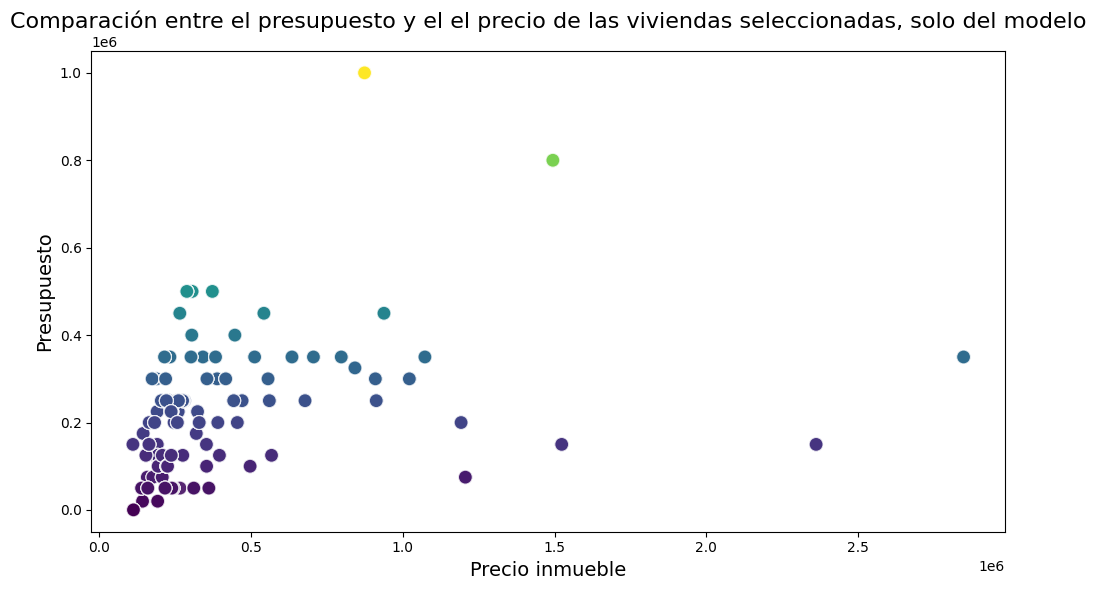

In [ ]:
# Visualizamos la diferencia entre el presupuesto y el precio de las viviendas seleccionadas por el KNN

resultados_prova = resultados_prova[resultados_prova['origen_vivienda'] == 'modelo_precio']
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='price_y', 
    y='budget',  
    data=resultados_prova,  
    hue='budget',  
    palette='viridis',  
    alpha=0.7,  
    s=100,  
    legend=False 
)

plt.title('Comparación entre el presupuesto y el el precio de las viviendas seleccionadas, solo del modelo', fontsize=16)
plt.xlabel('Precio inmueble', fontsize=14)
plt.ylabel('Presupuesto', fontsize=14)

plt.tight_layout()

plt.show()

In [40]:
(resultados_prova['budget'] - resultados_prova['price_x']).describe()

count       487.00
mean     -20777.52
std       89715.25
min     -150000.00
25%     -100000.00
50%      -35000.00
75%       52000.00
max      150000.00
dtype: float64

In [41]:
encuesta_prueba = encuesta2[['Dirección de correo electrónico','precio_predicho_distrito_1', 'precio_predicho_distrito_2']]

In [42]:
pruba_final = pd.merge(
    pruba_final, 
    encuesta_prueba, 
    left_on='Dirección de correo electrónico', 
    right_on='Dirección de correo electrónico', 
    how='left'
)

In [43]:
pruba_final['precio_predicho_distrito_1'] = pruba_final['precio_predicho_distrito_1'].str.replace('€', '').str.replace(',', '').astype(float)
pruba_final['precio_predicho_distrito_2'] = pruba_final['precio_predicho_distrito_2'].str.replace('€', '').str.replace(',', '').astype(float)
pruba_final['mean_predict'] = (pruba_final['precio_predicho_distrito_1'] + pruba_final['precio_predicho_distrito_2']) / 2

In [44]:
pruba_final['diferencia'] = pruba_final['budget'] - pruba_final['mean_predict']


In [45]:
pruba_final['tipo_diferencia'].value_counts()

tipo_diferencia
Negativo    75
Positivo    23
Name: count, dtype: int64